In [1]:
# These are all the modules we'll be using later.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import scipy.io   
import h5py

import matplotlib.pyplot as plt

import os
import sys
import tarfile
from IPython.display import display, Image

from scipy import ndimage

import random

%matplotlib inline

### Load dataset

In [46]:
pickle_file = 'SVHN_single_grey.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_label = save['train_label']
    valid_dataset = save['valid_dataset']
    valid_label = save['valid_label']
    test_dataset = save['test_dataset']f
    test_label = save['test_label']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_label.shape)
    print('Validation set', valid_dataset.shape, valid_label.shape)
    print('Test set', test_dataset.shape, test_label.shape)

Training set (65257, 32, 32) (65257,)
Validation set (10000, 32, 32) (10000,)
Test set (26032, 32, 32) (26032,)


In [9]:
def disp_sample_dataset(dataset, label):
    items = random.sample(range(dataset.shape[0]), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(label[i])
        plt.imshow(dataset[i])

TypeError: Invalid dimensions for image data

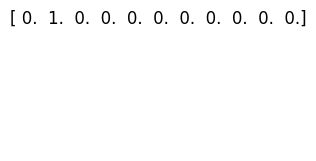

In [10]:
disp_sample_dataset(train_dataset, train_label)

In [2]:
pickle_file = 'SVHN_single_GCN.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_label = save['train_label']
    valid_dataset = save['valid_dataset']
    valid_label = save['valid_label']
    test_dataset = save['test_dataset']
    test_label = save['test_label']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_label.shape)
    print('Validation set', valid_dataset.shape, valid_label.shape)
    print('Test set', test_dataset.shape, test_label.shape)

Training set (65257, 32, 32) (65257,)
Validation set (10000, 32, 32) (10000,)
Test set (26032, 32, 32) (26032,)


In [3]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
    
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_label = reformat(train_dataset, train_label)
valid_dataset, valid_label = reformat(valid_dataset, valid_label)
test_dataset, test_label = reformat(test_dataset, test_label)
print('Training set', train_dataset.shape, train_label.shape)
print('Validation set', valid_dataset.shape, valid_label.shape)
print('Test set', test_dataset.shape, test_label.shape)

Training set (65257, 32, 32, 1) (65257, 11)
Validation set (10000, 32, 32, 1) (10000, 11)
Test set (26032, 32, 32, 1) (26032, 11)


### Metric

In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [13]:
test_dataset = test_dataset[:6000,:]
test_label = test_label[:6000,:]
print('Test set', test_dataset.shape, test_label.shape)

Test set (6000, 32, 32, 1) (6000, 11)


### Model 1

In [14]:
batch_size = 128
patch_size = 5
depth1 = 16
depth2 = 32
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    def weight_varible(shape):
        initial = tf.truncated_normal(shape, stddev = 0.1)
        return tf.Variable(initial)

    def bias_varible(shape):
        initial = tf.constant(0.1, shape = shape)
        return tf.Variable(initial)
    
    def conv2d(data, weight):
        # strides [1, x_movement, y_movement, 1]
        return tf.nn.conv2d(data, weight, strides = [1, 1, 1, 1], padding = 'SAME')

    def max_pooling(data):
        return tf.nn.max_pool(data, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    
    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    
    # Varibles
    # conv1 layer 1
    layer1_weights = weight_varible([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_varible([depth1]) # 16
    # conv2 layer 2
    layer2_weights = weight_varible([patch_size, patch_size, depth1, depth2]) # in depth1, out depth2
    layer2_biases = bias_varible([depth2]) # 32
    # func1 layer 3
    layer3_weights = weight_varible([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_varible([num_hidden])
    # func2 layer 4
    layer4_weights = weight_varible([num_hidden, num_labels])
    layer4_biases = bias_varible([num_labels])
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    def model(dataset):
        # conv1 layer 1
        hidden1 = tf.nn.relu(conv2d(dataset, layer1_weights) + layer1_biases) # 32 * 32 * depth1
        pool1 = max_pooling(hidden1) # 16 * 16 * depth1
        # conv2 layer 2
        hidden2 = tf.nn.relu(conv2d(pool1, layer2_weights) + layer2_biases) # 16 * 16 * depth2
        pool2 = max_pooling(hidden2) # 8 * 8 * depth2
        
        shape = pool2.get_shape().as_list()
        pool2_flat = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])

#         print([shape[0], shape[1] * shape[2] * shape[3]])
#         print([image_size // 4 * image_size // 4 * depth2, num_hidden])
        
        # func1 layer 3
        hidden3 = tf.nn.relu(tf.matmul(pool2_flat, layer3_weights) + layer3_biases)
        hidden3_drop = tf.nn.dropout(hidden3, 0.5)
        # func2 layer 4
        prediction = tf.matmul(hidden3_drop, layer4_weights) + layer4_biases
        return prediction
    
    
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
#     learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [15]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_label.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_label[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_label))
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_label))

Initialized
Minibatch loss at step 0: 15.628929
Minibatch accuracy: 7.8%
Validation accuracy: 15.1%
Minibatch loss at step 500: 2.077304
Minibatch accuracy: 28.9%
Validation accuracy: 30.3%
Minibatch loss at step 1000: 0.942447
Minibatch accuracy: 69.5%
Validation accuracy: 71.0%
Minibatch loss at step 1500: 0.664422
Minibatch accuracy: 82.0%
Validation accuracy: 80.0%
Minibatch loss at step 2000: 0.622747
Minibatch accuracy: 78.1%
Validation accuracy: 82.2%
Minibatch loss at step 2500: 0.516402
Minibatch accuracy: 87.5%
Validation accuracy: 84.1%
Minibatch loss at step 3000: 0.246544
Minibatch accuracy: 93.8%
Validation accuracy: 84.9%
Minibatch loss at step 3500: 0.329750
Minibatch accuracy: 91.4%
Validation accuracy: 85.9%
Minibatch loss at step 4000: 0.517766
Minibatch accuracy: 85.2%
Validation accuracy: 85.5%
Minibatch loss at step 4500: 0.453663
Minibatch accuracy: 87.5%
Validation accuracy: 86.0%
Minibatch loss at step 5000: 0.410853
Minibatch accuracy: 89.8%
Validation accurac

## V2


In [5]:
batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden = 256

graph = tf.Graph()

with graph.as_default():

    def weight_varible(shape):
        initial = tf.truncated_normal(shape, stddev = 0.1)
        return tf.Variable(initial)

    def bias_varible(shape):
        initial = tf.constant(0.1, shape = shape)
        return tf.Variable(initial)
    
    def conv2d(data, weight):
        # strides [1, x_movement, y_movement, 1]
        return tf.nn.conv2d(data, weight, strides = [1, 1, 1, 1], padding = 'SAME')

    def max_pooling(data):
        return tf.nn.max_pool(data, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    
    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    
    # Varibles
    # conv1 layer 1
    layer1_weights = weight_varible([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_varible([depth1]) # 16
    # conv2 layer 2
    layer2_weights = weight_varible([patch_size, patch_size, depth1, depth2]) # in depth1, out depth2
    layer2_biases = bias_varible([depth2]) # 32
    # conv3 layer 3
    layer3_weights = weight_varible([patch_size, patch_size, depth2, depth3]) # in depth2, out depth3
    layer3_biases = bias_varible([depth3]) # 64
    
    
    # func1 layer 4
    layer4_weights = weight_varible([image_size // 8 * image_size // 8 * depth3, num_hidden])
    layer4_biases = bias_varible([num_hidden])
    # func2 layer 5
    layer5_weights = weight_varible([num_hidden, num_labels])
    layer5_biases = bias_varible([num_labels])
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    def model(dataset):
        # conv1 layer 1
        hidden1 = tf.nn.relu(conv2d(dataset, layer1_weights) + layer1_biases) # 32 * 32 * depth1
        pool1 = max_pooling(hidden1) # 16 * 16 * depth1
        # conv2 layer 2
        hidden2 = tf.nn.relu(conv2d(pool1, layer2_weights) + layer2_biases) # 16 * 16 * depth2
        pool2 = max_pooling(hidden2) # 8 * 8 * depth2
        # conv3 layer 3
        hidden3 = tf.nn.relu(conv2d(pool2, layer3_weights) + layer3_biases) # 8 * 8 * depth2
        pool3 = max_pooling(hidden3) # 4 * 4 * depth3
        
        shape = pool3.get_shape().as_list()
        pool3_flat = tf.reshape(pool3, [shape[0], shape[1] * shape[2] * shape[3]])
        
        # func1 layer 4
        hidden4 = tf.nn.relu(tf.matmul(pool3_flat, layer4_weights) + layer4_biases)
        hidden4_drop = tf.nn.dropout(hidden4, 0.5)
        # func2 layer 5
        prediction = tf.matmul(hidden4_drop, layer5_weights) + layer5_biases
        return prediction
    
    
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
#     learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_label.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_label[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_label))
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_label))

Initialized
Minibatch loss at step 0: 9.210263
Minibatch accuracy: 12.5%
Validation accuracy: 15.4%
Minibatch loss at step 500: 0.766914
Minibatch accuracy: 76.6%
Validation accuracy: 78.5%
Minibatch loss at step 1000: 0.582334
Minibatch accuracy: 79.7%
Validation accuracy: 83.5%
Minibatch loss at step 1500: 0.462840
Minibatch accuracy: 81.2%
Validation accuracy: 86.5%
Minibatch loss at step 2000: 0.463819
Minibatch accuracy: 76.6%
Validation accuracy: 87.1%
Minibatch loss at step 2500: 0.411822
Minibatch accuracy: 93.8%
Validation accuracy: 88.7%
Minibatch loss at step 3000: 0.376943
Minibatch accuracy: 87.5%
Validation accuracy: 89.0%
Minibatch loss at step 3500: 0.196536
Minibatch accuracy: 95.3%
Validation accuracy: 89.1%
Minibatch loss at step 4000: 0.454912
Minibatch accuracy: 85.9%
Validation accuracy: 90.3%
Minibatch loss at step 4500: 0.316618
Minibatch accuracy: 85.9%
Validation accuracy: 89.6%
Minibatch loss at step 5000: 0.185370
Minibatch accuracy: 93.8%
Validation accurac

In [14]:
batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden = 256

graph = tf.Graph()

with graph.as_default():

    def weight_varible(shape):
        initial = tf.truncated_normal(shape, stddev = 0.1)
        return tf.Variable(initial)

    def bias_varible(shape):
        initial = tf.constant(0.1, shape = shape)
        return tf.Variable(initial)
    
    def conv2d(data, weight):
        # strides [1, x_movement, y_movement, 1]
        return tf.nn.conv2d(data, weight, strides = [1, 1, 1, 1], padding = 'VALID')

    def max_pooling(data):
        return tf.nn.max_pool(data, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    
    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    
    # Varibles
    # conv1 layer 1
    layer1_weights = weight_varible([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_varible([depth1]) # 16
    # conv2 layer 2
    layer2_weights = weight_varible([patch_size, patch_size, depth1, depth2]) # in depth1, out depth2
    layer2_biases = bias_varible([depth2]) # 32
    # conv3 layer 3
    layer3_weights = weight_varible([patch_size, patch_size, depth2, depth3]) # in depth2, out depth3
    layer3_biases = bias_varible([depth3]) # 64
    
    
    # func1 layer 4
    layer4_weights = weight_varible([image_size // 32 * image_size // 32 * depth3, num_hidden])
    layer4_biases = bias_varible([num_hidden])
    # func2 layer 5
    layer5_weights = weight_varible([num_hidden, num_labels])
    layer5_biases = bias_varible([num_labels])
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    def model(dataset, keep_prob):
        # conv1 layer 1
        hidden1 = tf.nn.relu(conv2d(dataset, layer1_weights) + layer1_biases) # 28 * 28 * depth1
        pool1 = max_pooling(hidden1) # 14 * 14 * depth1
        # conv2 layer 2
        hidden2 = tf.nn.relu(conv2d(pool1, layer2_weights) + layer2_biases) # 10 * 10 * depth2
        pool2 = max_pooling(hidden2) # 5 * 5 * depth2
        # conv3 layer 3
        pool3 = tf.nn.relu(conv2d(pool2, layer3_weights) + layer3_biases) # 1 * 1 * depth3
#         pool3 = max_pooling(hidden3) # 1 * 1 * depth3
        
        
        shape = pool3.get_shape().as_list()
        pool3_flat = tf.reshape(pool3, [shape[0], shape[1] * shape[2] * shape[3]])
        
        # func1 layer 4
        hidden4 = tf.nn.relu(tf.matmul(pool3_flat, layer4_weights) + layer4_biases)
        hidden4_drop = tf.nn.dropout(hidden4, keep_prob)
        # func2 layer 5
        prediction = tf.matmul(hidden4_drop, layer5_weights) + layer5_biases
        return prediction
    
    
    # Training computation.
    logits = model(tf_train_dataset, 0.5)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.001, global_step, 1000, 0.90, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(model(tf_train_dataset, 1.0))
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))

In [15]:
num_steps = 10001

with tf.Session(graph=graph) as session:
#     writer = tf.train.SummaryWriter("logs/", session.graph)
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_label.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_label[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_label))
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_label))

Initialized
Minibatch loss at step 0: 3.292156
Minibatch accuracy: 10.9%
Validation accuracy: 11.8%
Minibatch loss at step 500: 0.678820
Minibatch accuracy: 82.8%
Validation accuracy: 85.4%
Minibatch loss at step 1000: 0.627725
Minibatch accuracy: 79.7%
Validation accuracy: 86.7%
Minibatch loss at step 1500: 0.406221
Minibatch accuracy: 85.9%
Validation accuracy: 88.3%
Minibatch loss at step 2000: 0.398645
Minibatch accuracy: 89.1%
Validation accuracy: 89.2%
Minibatch loss at step 2500: 0.231271
Minibatch accuracy: 93.8%
Validation accuracy: 89.7%
Minibatch loss at step 3000: 0.325885
Minibatch accuracy: 93.8%
Validation accuracy: 89.8%
Minibatch loss at step 3500: 0.197270
Minibatch accuracy: 93.8%
Validation accuracy: 90.2%
Minibatch loss at step 4000: 0.408744
Minibatch accuracy: 89.1%
Validation accuracy: 90.8%
Minibatch loss at step 4500: 0.240521
Minibatch accuracy: 90.6%
Validation accuracy: 90.5%
Minibatch loss at step 5000: 0.201351
Minibatch accuracy: 93.8%
Validation accurac

In [19]:
batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 64
depth3 = 128
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    def weight_varible(shape):
        initial = tf.truncated_normal(shape, stddev = 0.1)
        return tf.Variable(initial)

    def bias_varible(shape):
        initial = tf.constant(0.1, shape = shape)
        return tf.Variable(initial)
    
    def conv2d(data, weight):
        # strides [1, x_movement, y_movement, 1]
        return tf.nn.conv2d(data, weight, strides = [1, 1, 1, 1], padding = 'SAME')

    def max_pooling(data):
        return tf.nn.max_pool(data, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    
    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    
    # Varibles
    # conv1 layer 1
    layer1_weights = weight_varible([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_varible([depth1]) # 16
    # conv2 layer 2
    layer2_weights = weight_varible([patch_size, patch_size, depth1, depth2]) # in depth1, out depth2
    layer2_biases = bias_varible([depth2]) # 32
    # conv3 layer 3
    layer3_weights = weight_varible([patch_size, patch_size, depth2, depth3]) # in depth2, out depth3
    layer3_biases = bias_varible([depth3]) # 64
    
    
    # func1 layer 4
    layer4_weights = weight_varible([image_size // 4 * image_size // 4 * depth3, num_hidden])
    layer4_biases = bias_varible([num_hidden])
    # func2 layer 5
    layer5_weights = weight_varible([num_hidden, num_labels])
    layer5_biases = bias_varible([num_labels])
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    def model(dataset, keep_prob):
        # conv1 layer 1
        hidden1 = tf.nn.relu(conv2d(dataset, layer1_weights) + layer1_biases) # 32 * 32 * depth1
#         hidden1 = tf.nn.local_response_normalization(hidden1)
        pool1 = max_pooling(hidden1) # 16 * 16 * depth1
        # conv2 layer 2
        hidden2 = tf.nn.relu(conv2d(pool1, layer2_weights) + layer2_biases) # 16 * 16 * depth2
#         hidden2 = tf.nn.local_response_normalization(hidden2)
        pool2 = max_pooling(hidden2) # 8 * 8 * depth2
        # conv3 layer 3
        pool3 = tf.nn.relu(conv2d(pool2, layer3_weights) + layer3_biases) # 8 * 8 * depth3
#         pool3 = max_pooling(hidden3) # 4 * 4 * depth3
        
        
        shape = pool3.get_shape().as_list()
        pool3_flat = tf.reshape(pool3, [shape[0], shape[1] * shape[2] * shape[3]])
        
        # func1 layer 4
        hidden4 = tf.nn.relu(tf.matmul(pool3_flat, layer4_weights) + layer4_biases)
        hidden4_drop = tf.nn.dropout(hidden4, keep_prob)
        # func2 layer 5
        prediction = tf.matmul(hidden4_drop, layer5_weights) + layer5_biases
        return prediction
    
    
    # Training computation.
    logits = model(tf_train_dataset, 0.5)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) #+ beta_regul * tf.nn.l2_loss(layer5_weights)

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.001, global_step, 1000, 0.90, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(model(tf_train_dataset, 1.0))
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))


In [20]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_label.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_label[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_label))
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_label))

Initialized
Minibatch loss at step 0: 13.523302
Minibatch accuracy: 7.8%
Validation accuracy: 14.4%
Minibatch loss at step 500: 2.010320
Minibatch accuracy: 42.2%
Validation accuracy: 46.8%
Minibatch loss at step 1000: 1.525942
Minibatch accuracy: 68.8%
Validation accuracy: 77.4%
Minibatch loss at step 1500: 0.580745
Minibatch accuracy: 84.4%
Validation accuracy: 86.4%
Minibatch loss at step 2000: 0.595862
Minibatch accuracy: 85.9%
Validation accuracy: 88.7%
Minibatch loss at step 2500: 0.524747
Minibatch accuracy: 92.2%
Validation accuracy: 89.9%
Minibatch loss at step 3000: 0.464406
Minibatch accuracy: 89.1%
Validation accuracy: 90.4%
Minibatch loss at step 3500: 0.235530
Minibatch accuracy: 96.9%
Validation accuracy: 91.2%
Minibatch loss at step 4000: 0.479353
Minibatch accuracy: 90.6%
Validation accuracy: 91.5%
Minibatch loss at step 4500: 0.287734
Minibatch accuracy: 93.8%
Validation accuracy: 91.8%
Minibatch loss at step 5000: 0.455840
Minibatch accuracy: 95.3%
Validation accurac

### Final Model

In [25]:
batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 64
depth3 = 128
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    def weight_varible(shape):
        initial = tf.truncated_normal(shape, stddev = 0.1)
        return tf.Variable(initial)

    def bias_varible(shape):
        initial = tf.constant(0.1, shape = shape)
        return tf.Variable(initial)
    
    def conv2d(data, weight):
        # strides [1, x_movement, y_movement, 1]
        return tf.nn.conv2d(data, weight, strides = [1, 1, 1, 1], padding = 'SAME')

    def max_pooling(data):
        return tf.nn.max_pool(data, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    
    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    
    # Varibles
    # conv1 layer 1
    layer1_weights = weight_varible([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_varible([depth1]) # 16
    # conv2 layer 2
    layer2_weights = weight_varible([patch_size, patch_size, depth1, depth2]) # in depth1, out depth2
    layer2_biases = bias_varible([depth2]) # 32
    # conv3 layer 3
    layer3_weights = weight_varible([patch_size, patch_size, depth2, depth3]) # in depth2, out depth3
    layer3_biases = bias_varible([depth3]) # 64
    
    
    # func1 layer 4
    layer4_weights = weight_varible([image_size // 4 * image_size // 4 * depth3, num_hidden])
    layer4_biases = bias_varible([num_hidden])
    # func2 layer 5
    layer5_weights = weight_varible([num_hidden, num_labels])
    layer5_biases = bias_varible([num_labels])
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    def model(dataset, keep_prob):
        # conv1 layer 1
        hidden1 = tf.nn.relu(conv2d(dataset, layer1_weights) + layer1_biases) # 32 * 32 * depth1
#         hidden1 = tf.nn.local_response_normalization(hidden1)
        pool1 = max_pooling(hidden1) # 16 * 16 * depth1
        # conv2 layer 2
        hidden2 = tf.nn.relu(conv2d(pool1, layer2_weights) + layer2_biases) # 16 * 16 * depth2
#         hidden2 = tf.nn.local_response_normalization(hidden2)
        pool2 = max_pooling(hidden2) # 8 * 8 * depth2
        # conv3 layer 3
        pool3 = tf.nn.relu(conv2d(pool2, layer3_weights) + layer3_biases) # 8 * 8 * depth3
        pool3 = max_pooling(hidden3) # 4 * 4 * depth3
        
        
        shape = pool3.get_shape().as_list()
        pool3_flat = tf.reshape(pool3, [shape[0], shape[1] * shape[2] * shape[3]])
        
        # func1 layer 4
        hidden4 = tf.nn.relu(tf.matmul(pool3_flat, layer4_weights) + layer4_biases)
        hidden4_drop = tf.nn.dropout(hidden4, keep_prob)
        # func2 layer 5
        prediction = tf.matmul(hidden4_drop, layer5_weights) + layer5_biases
        return prediction
    
    
    # Training computation.
    logits = model(tf_train_dataset, 0.5)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * tf.nn.l2_loss(layer5_weights)

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.001, global_step, 1000, 0.90, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(model(tf_train_dataset, 1.0))
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))


In [26]:
num_steps = 10001

with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_label.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_label[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_label))
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_label))

Initialized
Minibatch loss at step 0: 9.831328
Minibatch accuracy: 12.5%
Validation accuracy: 13.2%
Minibatch loss at step 500: 1.983049
Minibatch accuracy: 40.6%
Validation accuracy: 40.2%
Minibatch loss at step 1000: 1.251227
Minibatch accuracy: 70.3%
Validation accuracy: 77.0%
Minibatch loss at step 1500: 0.904425
Minibatch accuracy: 85.9%
Validation accuracy: 86.1%
Minibatch loss at step 2000: 0.785581
Minibatch accuracy: 79.7%
Validation accuracy: 88.1%
Minibatch loss at step 2500: 0.458895
Minibatch accuracy: 95.3%
Validation accuracy: 89.8%
Minibatch loss at step 3000: 0.523632
Minibatch accuracy: 87.5%
Validation accuracy: 90.3%
Minibatch loss at step 3500: 0.376672
Minibatch accuracy: 95.3%
Validation accuracy: 90.8%
Minibatch loss at step 4000: 0.612246
Minibatch accuracy: 87.5%
Validation accuracy: 91.7%
Minibatch loss at step 4500: 0.259714
Minibatch accuracy: 92.2%
Validation accuracy: 91.6%
Minibatch loss at step 5000: 0.206135
Minibatch accuracy: 95.3%
Validation accurac